In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import typing
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

np.random.seed(42)

In [2]:
wind_dir = {'Ветер, дующий с востока': 0,
            'Ветер, дующий с востоко-северо-востока': 45/2,
            'Ветер, дующий с северо-востока': 45,
            'Ветер, дующий с северо-северо-востока': 45 + 45/2,
            'Ветер, дующий с севера': 90,
            'Ветер, дующий с северо-северо-запад': 90 + 45/2,
            'Ветер, дующий с северо-запада': 135,
            'Ветер, дующий с западо-северо-запада': 135 + 45/2,
            'Ветер, дующий с запада': 180,
            'Ветер, дующий с западо-юго-запада': 180+45/2,
            'Ветер, дующий с юго-запада': 225,
            'Ветер, дующий с юго-юго-запада': 225 + 45/2,
            'Ветер, дующий с юга': 270,
            'Ветер, дующий с юго-юго-востока': 270 + 45/2,
            'Ветер, дующий с юго-востока': 315,
            'Ветер, дующий с востоко-юго-востока': 315 + 45/2,
            'Штиль, безветрие': None,
            }

In [3]:
def prepare_features(data: pd.DataFrame) -> pd.DataFrame:
    """Features preparation for anomaly detection and clustering"""
    # textual values encoding
    data['hum_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['pres_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['wind_speed'] = data.hum_meteo.fillna(method='bfill')
    data['temp_meteo'] = data.temp_meteo.fillna(method='bfill')
    data['prec_amount'] = data.prec_amount.fillna(method='bfill')
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)

    
    # fill missing value before PCA
    data['P1'] = data.P1.interpolate()
    
    for c in data.columns:
        data[c].fillna((data[c].mean()), inplace=True)
    
    return data

In [4]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')
data.columns

Index(['P1', 'P2', 'pressure', 'temperature', 'humidity', 'temp_meteo',
       'pres_meteo', 'hum_meteo', 'wind_direction', 'wind_speed',
       'precipitation', 'prec_amount', 'visibility', 'dew_point_temp'],
      dtype='object')

In [5]:
sel_columns = ['P1','hum_meteo', 'temp_meteo', 'pres_meteo', 'wind_speed', 'prec_amount',
               'pressure', 'temperature', 'humidity',]

In [6]:
data = data[sel_columns]
data = prepare_features(data)

In [7]:
data['day_of_week'] = data.index.dayofweek
data['weekend'] = data.day_of_week.apply(lambda d: d == 5 or d == 6).astype(int)
data['hour'] = data.index.hour
data['night'] = data.hour.apply(lambda h: 0<= h < 7).astype(int)
data['morning'] = data.hour.apply(lambda h: 7<= h < 12).astype(int)
data['day'] = data.hour.apply(lambda h: 12<= h < 17).astype(int)
data['evening'] = data.hour.apply(lambda h: 17<= h < 24).astype(int)
data['sin_day'] = np.sin(2*np.pi*data.day_of_week/7)
data['cos_day'] = np.cos(2*np.pi*data.day_of_week/7)
data['sin_hour'] = np.sin(2*np.pi*data.hour/24)
data['cos_hour'] = np.cos(2*np.pi*data.hour/24)

data.drop(columns=['day_of_week', 'hour', 'night', 'day', 'morning', 'evening'], inplace=True)

In [8]:
data = data.resample('1H').mean()

In [9]:
for c in data.columns:
    if data[c].isnull().values.any():
        print(c)

In [10]:
data.head()

,P1,hum_meteo,temp_meteo,pres_meteo,wind_speed,prec_amount,pressure,temperature,humidity,weekend,sin_day,cos_day,sin_hour,cos_hour
date,,,,,,,,,,,,,,
2019-04-01 00:00:00,5.897103,59.000000,6.70,59.000000,59.000000,0.0,98537.248924,6.936076,55.387396,0,0.0,1.0,0.000000,1.000000
2019-04-01 01:00:00,4.495774,59.000000,6.70,59.000000,59.000000,0.0,98592.497813,6.386736,53.921771,0,0.0,1.0,0.258819,0.965926
2019-04-01 02:00:00,4.090302,59.000000,6.70,59.000000,59.000000,0.0,98676.193542,5.564792,56.008229,0,0.0,1.0,0.500000,0.866025
2019-04-01 03:00:00,6.187858,60.833333,5.05,60.833333,60.833333,0.0,98767.538403,4.671840,60.999618,0,0.0,1.0,0.707107,0.707107
2019-04-01 04:00:00,3.100704,61.000000,4.90,61.000000,61.000000,0.0,98861.067153,4.998715,60.602222,0,0.0,1.0,0.866025,0.500000


In [11]:
def pp(start, end, n):
    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.DatetimeIndex((10**9*np.random.randint(start_u, end_u, n)).view('M8[ns]'))

In [12]:
start_idx = data.index[0]
end_idx = data.index[-1] - datetime.timedelta(days=2)
num_samples = 1500

In [13]:
def generate_chanks(series, n, start, end):
    chanks = []
    for idx in pp(start, end, n):
        c = series[str(idx):str(idx+datetime.timedelta(days=2))]
        chanks.append(c)
    return chanks

In [14]:
chanks = generate_chanks(data, num_samples, start_idx, end_idx)

In [15]:
data.columns

Index(['P1', 'hum_meteo', 'temp_meteo', 'pres_meteo', 'wind_speed',
       'prec_amount', 'pressure', 'temperature', 'humidity', 'weekend',
       'sin_day', 'cos_day', 'sin_hour', 'cos_hour'],
      dtype='object')

In [16]:
target_column = 'P1'
columns = ['P1', 'pressure', 'temperature', 'humidity']

In [17]:
def create_sample(chank, target_col, columns):
    X = dict()
    y = dict()
    d1 = chank.iloc[:24]
    d2 = chank.iloc[24:]
    for i in range(24):
        for c in columns:
            X[f'{c}_lag_{i}'] = d1[target_col][-(i+1)]
        y[f'{target_col}_forec_{i}'] = d2[target_col][i]
    return X, y
    

In [18]:
def prepare_data_from_chanks(chanks, target, col):
    df = pd.DataFrame(index=range(len(chanks)))
    for i in range(len(chanks)):
        x, y = create_sample(chanks[i], target, col)
        #print(x, y)
        for key, value in x.items():
            df.loc[i, key] = value
        for key, value in y.items():
            df.loc[i, key] = value
    return df

In [19]:
df = prepare_data_from_chanks(chanks, target_column, columns)

In [20]:
df.head()

,P1_lag_0,pressure_lag_0,temperature_lag_0,humidity_lag_0,P1_lag_1,pressure_lag_1,temperature_lag_1,humidity_lag_1,P1_lag_2,pressure_lag_2,...,P1_forec_14,P1_forec_15,P1_forec_16,P1_forec_17,P1_forec_18,P1_forec_19,P1_forec_20,P1_forec_21,P1_forec_22,P1_forec_23
0,72.789728,72.789728,72.789728,72.789728,67.734152,67.734152,67.734152,67.734152,63.419125,63.419125,...,24.093406,20.050236,22.225619,22.905058,23.455595,22.686901,22.783294,24.106390,27.334777,35.165661
1,8.003139,8.003139,8.003139,8.003139,8.470666,8.470666,8.470666,8.470666,8.426548,8.426548,...,7.686551,6.431607,5.493934,4.934640,6.008252,6.717623,5.636171,4.370779,4.837940,5.305594
2,39.440934,39.440934,39.440934,39.440934,40.713151,40.713151,40.713151,40.713151,43.602764,43.602764,...,11.320501,11.337687,10.389190,10.099167,9.516086,8.986262,8.601895,8.115241,8.444033,7.462515
3,5.420429,5.420429,5.420429,5.420429,5.414827,5.414827,5.414827,5.414827,5.724235,5.724235,...,15.673033,17.413850,20.235811,22.269894,22.489576,23.540574,23.897363,24.372181,23.597249,24.192394
4,41.618765,41.618765,41.618765,41.618765,39.888499,39.888499,39.888499,39.888499,36.229134,36.229134,...,18.872964,19.363339,18.465655,16.063664,13.261524,11.903197,12.740069,13.159749,12.690423,14.163106


In [21]:
x_columns = [i for i in df.columns if 'P1_forec_' not in i]
y_columns = [i for i in df.columns if 'P1_forec_' in i]

In [22]:
X, y = df[x_columns], df[y_columns]

In [23]:
for c in X.columns:
    if X[c].isnull().values.any():
        print(c)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
X_train.head()

,P1_lag_0,pressure_lag_0,temperature_lag_0,humidity_lag_0,P1_lag_1,pressure_lag_1,temperature_lag_1,humidity_lag_1,P1_lag_2,pressure_lag_2,...,temperature_lag_21,humidity_lag_21,P1_lag_22,pressure_lag_22,temperature_lag_22,humidity_lag_22,P1_lag_23,pressure_lag_23,temperature_lag_23,humidity_lag_23
485,4.056867,4.056867,4.056867,4.056867,4.289677,4.289677,4.289677,4.289677,3.883146,3.883146,...,6.651980,6.651980,6.820719,6.820719,6.820719,6.820719,7.713577,7.713577,7.713577,7.713577
527,11.601483,11.601483,11.601483,11.601483,13.868032,13.868032,13.868032,13.868032,13.208415,13.208415,...,5.772292,5.772292,5.575140,5.575140,5.575140,5.575140,5.934585,5.934585,5.934585,5.934585
199,10.727346,10.727346,10.727346,10.727346,11.003984,11.003984,11.003984,11.003984,11.619485,11.619485,...,9.709965,9.709965,8.442429,8.442429,8.442429,8.442429,8.683812,8.683812,8.683812,8.683812
889,71.639166,71.639166,71.639166,71.639166,58.790095,58.790095,58.790095,58.790095,58.954823,58.954823,...,90.013566,90.013566,63.171567,63.171567,63.171567,63.171567,54.530939,54.530939,54.530939,54.530939
844,20.320201,20.320201,20.320201,20.320201,19.367959,19.367959,19.367959,19.367959,18.737345,18.737345,...,7.468307,7.468307,7.663619,7.663619,7.663619,7.663619,8.258024,8.258024,8.258024,8.258024


In [26]:
#scaler = StandardScaler()
#col = X_train.columns
#X_train[col] = scaler.fit_transform(X_train[col])
#X_test[col] = scaler.transform(X_test[col])

In [27]:
X_train.head()

,P1_lag_0,pressure_lag_0,temperature_lag_0,humidity_lag_0,P1_lag_1,pressure_lag_1,temperature_lag_1,humidity_lag_1,P1_lag_2,pressure_lag_2,...,temperature_lag_21,humidity_lag_21,P1_lag_22,pressure_lag_22,temperature_lag_22,humidity_lag_22,P1_lag_23,pressure_lag_23,temperature_lag_23,humidity_lag_23
485,4.056867,4.056867,4.056867,4.056867,4.289677,4.289677,4.289677,4.289677,3.883146,3.883146,...,6.651980,6.651980,6.820719,6.820719,6.820719,6.820719,7.713577,7.713577,7.713577,7.713577
527,11.601483,11.601483,11.601483,11.601483,13.868032,13.868032,13.868032,13.868032,13.208415,13.208415,...,5.772292,5.772292,5.575140,5.575140,5.575140,5.575140,5.934585,5.934585,5.934585,5.934585
199,10.727346,10.727346,10.727346,10.727346,11.003984,11.003984,11.003984,11.003984,11.619485,11.619485,...,9.709965,9.709965,8.442429,8.442429,8.442429,8.442429,8.683812,8.683812,8.683812,8.683812
889,71.639166,71.639166,71.639166,71.639166,58.790095,58.790095,58.790095,58.790095,58.954823,58.954823,...,90.013566,90.013566,63.171567,63.171567,63.171567,63.171567,54.530939,54.530939,54.530939,54.530939
844,20.320201,20.320201,20.320201,20.320201,19.367959,19.367959,19.367959,19.367959,18.737345,18.737345,...,7.468307,7.468307,7.663619,7.663619,7.663619,7.663619,8.258024,8.258024,8.258024,8.258024


In [28]:
def get_mae(models, X_test, y_test, y_columns):
    scores = []
    for i in range(len(y_columns)):
        local_model = models[i]
        prediction = local_model.predict(X_test)
        mae = mean_absolute_error(y_test[y_columns[i]], prediction)
        scores.append(mae)
    return scores

In [29]:
def train_models(model, x_train, y_train, y_columns):
    models = []
    for i in range(len(y_columns)):
        local_model = clone(model)
        local_model.fit(x_train, y_train[y_columns[i]])
        models.append(local_model)
    return models

In [30]:
mod = Lasso(alpha=0.2, max_iter=2000)
models  = train_models(mod, X_train, y_train, y_columns)

In [31]:
mae = get_mae(models, X_test, y_test, y_columns)

In [32]:
mae, np.mean(mae)

([1.4943848434677398,
  2.790559551495723,
  3.57277596000193,
  4.42888167953089,
  5.315715554218751,
  5.889790628482667,
  6.477641797614389,
  6.911514313869167,
  7.299970123236289,
  7.505566502230722,
  7.514960332542531,
  7.422675511674773,
  7.493268864150977,
  7.7544500590249665,
  7.645126548390997,
  7.558650747507478,
  7.684944659334793,
  7.610413513053575,
  7.764492674592269,
  7.842342887697962,
  7.789908516795547,
  7.897329063652685,
  8.095952378878849,
  8.298025225192207],
 6.669139247359912)

In [33]:
mae, np.mean(mae)

([1.4943848434677398,
  2.790559551495723,
  3.57277596000193,
  4.42888167953089,
  5.315715554218751,
  5.889790628482667,
  6.477641797614389,
  6.911514313869167,
  7.299970123236289,
  7.505566502230722,
  7.514960332542531,
  7.422675511674773,
  7.493268864150977,
  7.7544500590249665,
  7.645126548390997,
  7.558650747507478,
  7.684944659334793,
  7.610413513053575,
  7.764492674592269,
  7.842342887697962,
  7.789908516795547,
  7.897329063652685,
  8.095952378878849,
  8.298025225192207],
 6.669139247359912)

In [34]:
def predict_on_chank(chank, models, columns, target_col='P1'):
    d1 = chank.iloc[:24]
    d2 = chank.iloc[24:]
    X = pd.DataFrame(index=range(1))
    for i in range(24):
        for c in columns:
            X[f'{c}_lag_{i}'] = d1[target_col][-(i+1)]
    y = d2[target_col]

    pred = []
    for i in range(len(models)):
        mod = models[i]
        pred.append(mod.predict(X)[0])
    return y,pred 

In [35]:
y_chank, pred = predict_on_chank(chanks[42], models, columns)

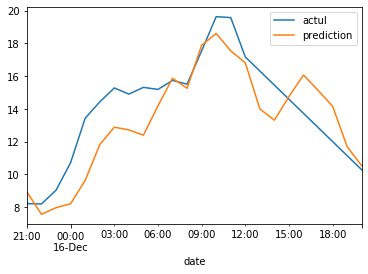

In [36]:
result = pd.DataFrame({'actul': y_chank})
result['prediction'] = pred
result.plot()

In [37]:
def print_coef(model):
    coef = pd.DataFrame(index=range(len(x_columns)))
    coef['featurs'] = x_columns
    coef['importance'] = model.coef_
    print(coef)